In [1]:
%matplotlib inline
import numpy as np
import azureml.core
from azureml.core import Workspace
from azureml.core.dataset import Dataset
# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import glob2
import pandas as pd

Azure ML SDK Version:  1.2.0


### Select the  model to be evaluated from workspace

In [2]:
workspace = Workspace.from_config()
workspace
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

checkboxes = []

for experiment_name, experiment in workspace.experiments.items():
    checkbox = widgets.Checkbox(
        value=False,
        description=experiment_name
    )
    display(checkbox)
    checkboxes.append(checkbox)

Checkbox(value=False, description='q2milestone-cnndepthmap-height')

Checkbox(value=False, description='q3-cnndepthmap-resnet-height')

Checkbox(value=False, description='q3-depthmap-plaincnn-height')

Checkbox(value=False, description='diabetes-experiment')

Checkbox(value=False, description='s2-gapnet-height')

Checkbox(value=False, description='pointnet-milestone-2019-height')

Checkbox(value=False, description='recreate_milestone_2019_height')

Checkbox(value=False, description='milestone-2019-height')

Checkbox(value=False, description='s1-milestone-2019-height')

Checkbox(value=False, description='q3-depthmap-plaincnn-height-95k')

Checkbox(value=False, description='q3-cnndepthmap-resnet-height-95k')

Checkbox(value=False, description='q3-depthmap-plaincnn-height-100-95k')

Checkbox(value=False, description='sklearn-mnist')

Checkbox(value=False, description='anon-depthmap-mini')

Checkbox(value=False, description='s1-gapnet-balanced')

Checkbox(value=False, description='q3-gapnet-balanced')

Checkbox(value=False, description='My-first-Experiment')

Checkbox(value=False, description='training-junkyard')

Checkbox(value=False, description='q2s1-cnndepthmap-height')

Checkbox(value=False, description='gapnet-offline')

Checkbox(value=False, description='q2-s4-standing-lying-classifier')

### Download the models on your local system for evaluation

In [ ]:
import shutil
# Get the selected experiments.
selected_experiments = []
for checkbox in checkboxes:
    if checkbox.value == True:
        selected_experiments.append(checkbox.description)

# Get folder.
temp_path = "logs"
if os.path.exists(temp_path):
    shutil.rmtree(temp_path)
os.mkdir(temp_path)

# For each selected experiment download logs of all completed runs.
for selected_experiment in selected_experiments:
    print("Experiment: {}".format(selected_experiment))
    experiment = workspace.experiments.get(selected_experiment)
    for run_index, run in enumerate(list(experiment.get_runs())[::-1]):
        log_path = os.path.join(temp_path, experiment.name, "run_{:02d}".format(run_index + 1))
#         if run.status == "Failed" and run.id == 'q3-depthmap-plaincnn-height_1595403832_d4528115':
        if  run.id == 'q3-depthmap-plaincnn-height-95k_1597988908_42c4ef33':
            print("Run: {}".format(run_index + 1))
            run.download_files(output_directory='logs/q3-depthmap-plaincnn-height-95k/run_03/', output_paths=None, batch_size=100, append_prefix=False)
#             run.download_files(prefix=".h5", output_directory=log_path, output_paths=None, batch_size=100, append_prefix=False)

print("Done.")

### Load the models

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model = load_model('evaluation_95k_30082020/q3-depthmap-plaincnn-height-100-95k/run_03/outputs/best_model.h5')
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 180, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 180, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 90, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 90, 64)       18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 90, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 45, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 45, 128)       7

## preprocessing the inputs 

In [4]:
image_target_height = 240
image_target_width =180

def tf_load_pickle(path):
    def py_load_pickle(path):
        depthmap, targets = pickle.load(open(path, "rb"))
        depthmap = preprocess_depthmap(depthmap)
        depthmap = depthmap/depthmap.max()
        depthmap = tf.image.resize(depthmap, (image_target_height, image_target_width))
        targets = preprocess_targets(targets, targets_indices)
        return depthmap, targets
    
    depthmap, targets = tf.py_function(py_load_pickle, [path], [tf.float32, tf.float32])
    depthmap.set_shape((image_target_height, image_target_width, 1))
    targets.set_shape((len(targets_indices,)))
    return depthmap, targets

In [5]:
def preprocess_targets(targets, targets_indices):
    if targets_indices is not None:
        targets = targets[targets_indices]
    return targets.astype("float32")

def preprocess_depthmap(depthmap):
    # TODO here be more code.
    return depthmap.astype("float32")

In [6]:
targets_indices = [0] # height =0 , weight =1

### Show a sample from the testset

depthmap_max: 1.0


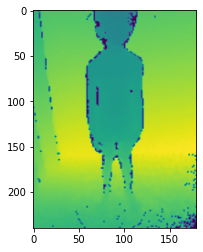

In [7]:
paths = '../testdepthmap1/1585551618-hlby208u8z/pc_1585551618-hlby208u8z_1593156356859_100_000.p'
depthmap, targets = pickle.load(open(paths, "rb"))
depthmap = preprocess_depthmap(depthmap)
depthmap = depthmap/depthmap.max()
print("depthmap_max:",depthmap.max())
depthmap = tf.image.resize(depthmap, (image_target_height, image_target_width))
targets = preprocess_targets(targets, targets_indices)
depthmap.set_shape((image_target_height, image_target_width, 1))
# targets.set_shape((len(targets_indices,)))
plt.imshow(np.squeeze(depthmap))

### Preprocess the samples from testset 

In [8]:
def preprocess(path):
    depthmap, targets = pickle.load(open(path, "rb"))
    depthmap = preprocess_depthmap(depthmap)
#     depthmap = depthmap/depthmap.max()
    depthmap = depthmap/7.5
    depthmap = tf.image.resize(depthmap, (image_target_height, image_target_width))
    targets = preprocess_targets(targets, targets_indices)
    depthmap.set_shape((image_target_height, image_target_width, 1))
    return depthmap,targets

### Perform the prediction

In [10]:
from tqdm.notebook import tqdm
predictions =[]
prediction_folder = glob2.glob('/mnt/depthmap/depthmap_testset/scans/*/*/') ## mount the dataset and provide the absolute path

['/mnt/depthmap/depthmap_testset/scans/1585004725-18cqo1np0j/100/',
 '/mnt/depthmap/depthmap_testset/scans/1585004725-18cqo1np0j/101/',
 '/mnt/depthmap/depthmap_testset/scans/1585004725-18cqo1np0j/102/',
 '/mnt/depthmap/depthmap_testset/scans/1585012629-ac1ippx2qy/100/',
 '/mnt/depthmap/depthmap_testset/scans/1585012629-ac1ippx2qy/101/',
 '/mnt/depthmap/depthmap_testset/scans/1585012629-ac1ippx2qy/102/',
 '/mnt/depthmap/depthmap_testset/scans/1585012645-ii2eyvdpib/100/',
 '/mnt/depthmap/depthmap_testset/scans/1585012645-ii2eyvdpib/101/',
 '/mnt/depthmap/depthmap_testset/scans/1585012645-ii2eyvdpib/102/',
 '/mnt/depthmap/depthmap_testset/scans/1585012682-ccfj5uwkr6/100/',
 '/mnt/depthmap/depthmap_testset/scans/1585012682-ccfj5uwkr6/101/',
 '/mnt/depthmap/depthmap_testset/scans/1585012682-ccfj5uwkr6/102/',
 '/mnt/depthmap/depthmap_testset/scans/1585012756-r5jc2vztha/100/',
 '/mnt/depthmap/depthmap_testset/scans/1585012756-r5jc2vztha/101/',
 '/mnt/depthmap/depthmap_testset/scans/158501275

In [11]:
predictions = []
for qrcode in tqdm(prediction_folder):
    depthmaps_pred = []
    labels = []
    depthfiles = []
    depthmaps = glob2.glob(qrcode+'*.p')
    for files in depthmaps:
        depths,targets = preprocess(files)
        depthmaps_pred.append(depths)
        labels.append(targets)
        depthfiles.append(files)
    files_to_predict  =tf.stack(depthmaps_pred)
    inference = model.predict(files_to_predict)
    predictions.append([qrcode,depthfiles,np.squeeze(inference),labels])

In [13]:
## putting the predictions in a dataframe
df = pd.DataFrame([])
for i in tqdm(range(len(predictions))):
    label = np.array(predictions[i][3])
    label =label.flatten()
    data =pd.DataFrame({'qrcode':predictions[i][0],'artifacts': predictions[i][1],'predicted':predictions[i][2],'GT':label})
    df = df.append(data)
df.head()

,qrcode,artifacts,predicted,GT
0,/mnt/depthmap/depthmap_testset/scans/158500472...,/mnt/depthmap/depthmap_testset/scans/158500472...,96.850517,96.800003
1,/mnt/depthmap/depthmap_testset/scans/158500472...,/mnt/depthmap/depthmap_testset/scans/158500472...,97.974648,96.800003
2,/mnt/depthmap/depthmap_testset/scans/158500472...,/mnt/depthmap/depthmap_testset/scans/158500472...,96.587715,96.800003
3,/mnt/depthmap/depthmap_testset/scans/158500472...,/mnt/depthmap/depthmap_testset/scans/158500472...,97.387077,96.800003
4,/mnt/depthmap/depthmap_testset/scans/158500472...,/mnt/depthmap/depthmap_testset/scans/158500472...,100.200615,96.800003


In [14]:
## function to extract the qrcode from the artifacts 
def qrcode(row):
    qrc = row['artifacts'].split('/')[5]
    return qrc

In [15]:
df['qrcode'] = df.apply(qrcode,axis=1)
df.head()

,qrcode,artifacts,predicted,GT
0,1585004725-18cqo1np0j,/mnt/depthmap/depthmap_testset/scans/158500472...,96.850517,96.800003
1,1585004725-18cqo1np0j,/mnt/depthmap/depthmap_testset/scans/158500472...,97.974648,96.800003
2,1585004725-18cqo1np0j,/mnt/depthmap/depthmap_testset/scans/158500472...,96.587715,96.800003
3,1585004725-18cqo1np0j,/mnt/depthmap/depthmap_testset/scans/158500472...,97.387077,96.800003
4,1585004725-18cqo1np0j,/mnt/depthmap/depthmap_testset/scans/158500472...,100.200615,96.800003


In [ ]:
df['artifacts'].iloc[1] # sample of how the artifacts path looks like for me, modify it accordingly to suit your path dependency

In [ ]:
len(df['qrcode'].unique()) ## total number of scans

In [16]:
## function to extract the scantype of artifacts and display the number 
def scantype(row):
    scans = row['artifacts'].split('/')[6]
    return scans

In [ ]:
"## keys for different scan type
"- 100 - standing front scan\"
""- 101 - standing 360 scan\",
"\"- 102 - standing back scan\",\n",
"\"- 200 - lying front scan\",\n",
"\"- 201 - lying side scan\",\n",
"\"- 202 - lying back scan\"\n"

In [17]:
df['scantype'] = df.apply(scantype, axis=1)
df['scantype'].value_counts()

101    29281
102    14088
100    13778
200       67
201       41
202       17
Name: scantype, dtype: int64

## group the results of artifacts by qrcode and scantype by taking mean across the same scantype

In [18]:
MAE = df.groupby(['qrcode','scantype']).mean()
MAE

predicted          GT
qrcode                scantype                        
1585004725-18cqo1np0j 100        97.310211   96.800003
                      101        96.979622   96.800003
                      102        95.953499   96.800003
1585012629-ac1ippx2qy 100        86.617508   87.300003
                      101        84.597847   87.300003
                      102        85.821121   87.300003
1585012645-ii2eyvdpib 100        94.827309  103.099998
                      101       100.420944  103.099998
                      102       103.631660  103.099998
1585012682-ccfj5uwkr6 100        90.374855   90.900002
                      101        89.795334   90.900002
                      102        92.119865   90.900002
1585012756-r5jc2vztha 100        84.300537   84.599998
                      101        83.921837   84.599998
                      102        84.081299   84.599998
1585012883-9c7qb46z18 100        79.473602   79.000000
                      101        82.809341   79.000000
                      102        80.883423   79.000000
1585012894-attzxjxvk6 100        96.962097   96.199997
                      101        95.063042   96.199997
                      102        98.013878   96.199997
1585012900-7zoh3rt514 100        73.659416   75.500000
                      101        77.632462   75.500000
                      102        80.834389   75.500000
1585012911-z7w6anteod 100        92.331177   90.500000
                      101        87.090134   90.500000
                      102        88.454140   90.500000
1585012942-9h61cut895 100        91.995605   92.199997
                      101        94.072983   92.199997
                      102        95.139923   92.199997
...                                    ...         ...
1585518561-hio4fwirpk 100        82.956985   79.699997
                      101        80.837875   79.699997
                      102        78.879562   79.699997
1585525357-5jzruer00u 100        96.575401   97.800003
                      101        95.589546   97.800003
                      102        95.024429   97.800003
1585525361-ciemx4m9k8 100        92.200798   91.199997
                      101        89.759552   91.199997
                      102        90.142540   91.199997
1585528967-125tiyaju4 100        91.343117   91.099998
                      101        91.817596   91.099998
                      102        91.225075   91.099998
1585532018-ny7bjt2qu0 100        88.983932   87.000000
                      101        86.622841   87.000000
                      102        87.323006   87.000000
1585532022-9blauh2c7v 100        94.918953   93.500000
                      101        91.220390   93.500000
                      102        96.044975   93.500000
1585541624-5hhjxbjehs 100        90.903755   87.800003
                      101        87.059784   87.800003
                      102        90.051979   87.800003
1585541628-umtrfuju0n 100        72.778938   72.900002
                      101        81.600403   72.900002
                      102        71.770187   72.900002
1585541632-vji2gatw4g 100       102.790863  103.400002
                      101       101.704842  103.400002
                      102       101.584518  103.400002
1585551618-hlby208u8z 100       103.409698  105.300003
                      101       104.110710  105.300003
                      102       100.806221  105.300003

[5249 rows x 2 columns]

## error between predicted and ground truth

In [19]:
def avgerror(row):
    difference =row['GT'] - row['predicted']
    return difference

In [20]:
MAE['error'] = MAE.apply(avgerror, axis=1)
MAE

predicted          GT     error
qrcode                scantype                                  
1585004725-18cqo1np0j 100        97.310211   96.800003 -0.510208
                      101        96.979622   96.800003 -0.179619
                      102        95.953499   96.800003  0.846504
1585012629-ac1ippx2qy 100        86.617508   87.300003  0.682495
                      101        84.597847   87.300003  2.702156
                      102        85.821121   87.300003  1.478882
1585012645-ii2eyvdpib 100        94.827309  103.099998  8.272690
                      101       100.420944  103.099998  2.679054
                      102       103.631660  103.099998 -0.531662
1585012682-ccfj5uwkr6 100        90.374855   90.900002  0.525146
                      101        89.795334   90.900002  1.104668
                      102        92.119865   90.900002 -1.219864
1585012756-r5jc2vztha 100        84.300537   84.599998  0.299461
                      101        83.921837   84.599998  0.678162
                      102        84.081299   84.599998  0.518700
1585012883-9c7qb46z18 100        79.473602   79.000000 -0.473602
                      101        82.809341   79.000000 -3.809341
                      102        80.883423   79.000000 -1.883423
1585012894-attzxjxvk6 100        96.962097   96.199997 -0.762100
                      101        95.063042   96.199997  1.136955
                      102        98.013878   96.199997 -1.813881
1585012900-7zoh3rt514 100        73.659416   75.500000  1.840584
                      101        77.632462   75.500000 -2.132462
                      102        80.834389   75.500000 -5.334389
1585012911-z7w6anteod 100        92.331177   90.500000 -1.831177
                      101        87.090134   90.500000  3.409866
                      102        88.454140   90.500000  2.045860
1585012942-9h61cut895 100        91.995605   92.199997  0.204391
                      101        94.072983   92.199997 -1.872986
                      102        95.139923   92.199997 -2.939926
...                                    ...         ...       ...
1585518561-hio4fwirpk 100        82.956985   79.699997 -3.256989
                      101        80.837875   79.699997 -1.137878
                      102        78.879562   79.699997  0.820435
1585525357-5jzruer00u 100        96.575401   97.800003  1.224602
                      101        95.589546   97.800003  2.210457
                      102        95.024429   97.800003  2.775574
1585525361-ciemx4m9k8 100        92.200798   91.199997 -1.000801
                      101        89.759552   91.199997  1.440445
                      102        90.142540   91.199997  1.057457
1585528967-125tiyaju4 100        91.343117   91.099998 -0.243118
                      101        91.817596   91.099998 -0.717598
                      102        91.225075   91.099998 -0.125076
1585532018-ny7bjt2qu0 100        88.983932   87.000000 -1.983932
                      101        86.622841   87.000000  0.377159
                      102        87.323006   87.000000 -0.323006
1585532022-9blauh2c7v 100        94.918953   93.500000 -1.418953
                      101        91.220390   93.500000  2.279610
                      102        96.044975   93.500000 -2.544975
1585541624-5hhjxbjehs 100        90.903755   87.800003 -3.103752
                      101        87.059784   87.800003  0.740219
                      102        90.051979   87.800003 -2.251976
1585541628-umtrfuju0n 100        72.778938   72.900002  0.121063
                      101        81.600403   72.900002 -8.700401
                      102        71.770187   72.900002  1.129814
1585541632-vji2gatw4g 100       102.790863  103.400002  0.609138
                      101       101.704842  103.400002  1.695160
                      102       101.584518  103.400002  1.815483
1585551618-hlby208u8z 100       103.409698  105.300003  1.890305
                      101       104.110710  105.300003  1.189293
   

In [23]:
## error margin on various ranges
evaluation_accuracies = [.2,.4,.8,1.2,2,2.5,3,4,5,6]

In [25]:
## froming the unique name for the index values
model_name = 'q3-depthmap-plaincnn-height-100-95k'
run_no ='_front_run_03'
complete_name = model_name+run_no

## calculating accuracies across the scantypes

In [26]:
Scan = '_360'
full_model_name = complete_name + Scan
rot = MAE.iloc[MAE.index.get_level_values('scantype') == '101']
accuracy_list =[]
for acc in evaluation_accuracies:
    predicted_rot = rot[(rot['error']<=acc) & (rot['error']>=-acc)]
    rot_accuracy = len(predicted_rot)/len(rot)*100
    print("total accuracy {} for 360:{}".format(acc,rot_accuracy))
    accuracy_list.append(rot_accuracy)
rotdata =pd.DataFrame(accuracy_list)
rotdata =rotdata.T
rotdata.columns = evaluation_accuracies
rotdata.rename(index={0:full_model_name}, inplace=True)
rotdata

total accuracy 0.2 for 360:5.103211009174312
total accuracy 0.4 for 360:9.747706422018348
total accuracy 0.8 for 360:20.126146788990827
total accuracy 1.2 for 360:31.25
total accuracy 2 for 360:50.17201834862385
total accuracy 2.5 for 360:59.977064220183486
total accuracy 3 for 360:68.17660550458714
total accuracy 4 for 360:79.87385321100918
total accuracy 5 for 360:86.52522935779817
total accuracy 6 for 360:91.05504587155964


,0.2,0.4,0.8,1.2,2.0,2.5,3.0,4.0,5.0,6.0
q3-depthmap-plaincnn-height-100-95k_front_run_03_360,5.103211,9.747706,20.126147,31.25,50.172018,59.977064,68.176606,79.873853,86.525229,91.055046


In [27]:
Scan = '_back'
full_model_name = complete_name + Scan
back = MAE.iloc[MAE.index.get_level_values('scantype') == '102']
print(len(back))
accuracy_list =[]
for acc in evaluation_accuracies:
    predicted_back = back[(back['error']<=acc) & (back['error']>=-acc)]
    back_accuracy = len(predicted_back)/len(back)*100
    print("total accuracy {} for back:{}".format(acc,back_accuracy))
    accuracy_list.append(back_accuracy)
backdata =pd.DataFrame(accuracy_list)
backdata =backdata.T
backdata.columns = evaluation_accuracies
backdata.rename(index={0:full_model_name}, inplace=True)
backdata

1743
total accuracy 0.2 for back:7.343660355708548
total accuracy 0.4 for back:14.74469305794607
total accuracy 0.8 for back:28.68617326448652
total accuracy 1.2 for back:41.365461847389554
total accuracy 2 for back:61.2736660929432
total accuracy 2.5 for back:69.87951807228916
total accuracy 3 for back:76.41996557659209
total accuracy 4 for back:85.65691336775674
total accuracy 5 for back:90.13195639701664
total accuracy 6 for back:94.14802065404476


,0.2,0.4,0.8,1.2,2.0,2.5,3.0,4.0,5.0,6.0
q3-depthmap-plaincnn-height-100-95k_front_run_03_back,7.34366,14.744693,28.686173,41.365462,61.273666,69.879518,76.419966,85.656913,90.131956,94.148021


In [29]:
Scan = '_front'
full_model_name = complete_name + Scan
front= MAE.iloc[MAE.index.get_level_values('scantype') == '100']
print("total front samples:",len(front))
accuracy_list =[]
for acc in evaluation_accuracies:
    predicted_front = front[(front['error']<=acc) & (front['error']>=-acc)]
    front_accuracy = len(predicted_front)/len(front)*100
    print("total accuracy {} for front:{}".format(acc,front_accuracy))
    accuracy_list.append(front_accuracy)
frontdata =pd.DataFrame(accuracy_list)
frontdata =frontdata.T
frontdata.columns = evaluation_accuracies
frontdata.rename(index={0:full_model_name}, inplace=True)
frontdata

total front samples: 1743
total accuracy 0.2 for front:8.89271371199082
total accuracy 0.4 for front:18.12966150315548
total accuracy 0.8 for front:34.99713138267355
total accuracy 1.2 for front:50.602409638554214
total accuracy 2 for front:72.00229489386116
total accuracy 2.5 for front:80.32128514056225
total accuracy 3 for front:85.25530694205393
total accuracy 4 for front:92.42685025817556
total accuracy 5 for front:94.60699942627654
total accuracy 6 for front:96.21342512908778


,0.2,0.4,0.8,1.2,2.0,2.5,3.0,4.0,5.0,6.0
q3-depthmap-plaincnn-height-100-95k_front_run_03_front,8.892714,18.129662,34.997131,50.60241,72.002295,80.321285,85.255307,92.42685,94.606999,96.213425


In [28]:
Scan = '_lyingfront'
full_model_name = complete_name + Scan
lyingfront= MAE.iloc[MAE.index.get_level_values('scantype') == '200']
print("total lyingfront samples:",len(lyingfront))
accuracy_list =[]
for acc in evaluation_accuracies:
    predicted_front = lyingfront[(lyingfront['error']<=acc) & (lyingfront['error']>=-acc)]
    front_accuracy = len(predicted_front)/len(lyingfront)*100
    print("total accuracy {} for lyingfront:{}".format(acc,front_accuracy))
    accuracy_list.append(front_accuracy)
lyingfrontdata =pd.DataFrame(accuracy_list)
lyingfrontdata =lyingfrontdata.T
lyingfrontdata.columns = evaluation_accuracies
lyingfrontdata.rename(index={0:full_model_name}, inplace=True)
lyingfrontdata

total lyingfront samples: 11
total accuracy 0.2 for lyingfront:0.0
total accuracy 0.4 for lyingfront:0.0
total accuracy 0.8 for lyingfront:0.0
total accuracy 1.2 for lyingfront:9.090909090909092
total accuracy 2 for lyingfront:9.090909090909092
total accuracy 2.5 for lyingfront:9.090909090909092
total accuracy 3 for lyingfront:9.090909090909092
total accuracy 4 for lyingfront:27.27272727272727
total accuracy 5 for lyingfront:45.45454545454545
total accuracy 6 for lyingfront:45.45454545454545


,0.2,0.4,0.8,1.2,2.0,2.5,3.0,4.0,5.0,6.0
q3-depthmap-plaincnn-height-100-95k_front_run_03_lyingfront,0.0,0.0,0.0,9.090909,9.090909,9.090909,9.090909,27.272727,45.454545,45.454545


In [ ]:
Scan = '_lyingrot'
full_model_name = complete_name + Scan
lyingrot= MAE.iloc[MAE.index.get_level_values('scantype') == '201']
print("total lyingrot samples:",len(lyingrot))
accuracy_list =[]
for acc in evaluation_accuracies:
    predicted_front = lyingrot[(lyingrot['error']<=acc) & (lyingrot['error']>=-acc)]
    front_accuracy = len(predicted_front)/len(lyingrot)*100
    print("total accuracy {} for lyingfront:{}".format(acc,front_accuracy))
    accuracy_list.append(front_accuracy)
lyingrotdata =pd.DataFrame(accuracy_list)
lyingrotdata =lyingrotdata.T
lyingrotdata.columns = evaluation_accuracies
lyingrotdata.rename(index={0:full_model_name}, inplace=True)
lyingrotdata

In [ ]:
Scan = '_lyingback'
full_model_name = complete_name + Scan
lyingback= MAE.iloc[MAE.index.get_level_values('scantype') == '202']
print("total lyingback samples:",len(lyingback))
accuracy_list =[]
for acc in evaluation_accuracies:
    predicted_back = lyingback[(lyingback['error']<=acc) & (lyingback['error']>=-acc)]
    back_accuracy = len(predicted_back)/len(lyingback)*100
    print("total accuracy {} for lyingback:{}".format(acc,back_accuracy))
    accuracy_list.append(back_accuracy)
lyingbackdata =pd.DataFrame(accuracy_list)
lyingbackdata =lyingbackdata.T
lyingbackdata.columns = evaluation_accuracies
lyingbackdata.rename(index={0:full_model_name}, inplace=True)
lyingbackdata

## combining the results for all accuracies

In [30]:
result  = pd.concat([frontdata, rotdata,backdata,lyingfrontdata,lyingrotdata,lyingbackdata])
result

NameError: name 'lyingrotdata' is not defined

In [ ]:
result.index.name = 'Model_Scantype'
# alldata.set_names('Model', level=None, inplace=True)
result

In [ ]:
## Saving the model results in csv file
result.to_csv('evaluation_95k_30082020/q3-depthmap-plaincnn-height-95k/run_03.csv',index=True)

In [ ]:
complete_results =pd.concat([run_03,run_04,front])
complete_results = complete_results.round(2) ## saving the results upto two decimal places

In [ ]:
complete_results.to_csv('Model_results/95k_data_v0/results.csv',index=True)